<a href="https://colab.research.google.com/github/OIEIEIO/supreme-octo-chainsaw/blob/main/Malevich_ruDALL_E_with_ESRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created by Ray Krehn ([www.krehnsolutions.com](https://www.krehnsolutions.com)).

This is an English version of the popular ruDALL-E text-to-image generation using DALL-E artificial intelligence. Please make a copy to your own Google Drive and and give thanks. 

Based on the Github ru-DALLE (https://github.com/sberbank-ai/ru-dalle), this works best for describing specific scenarios like "a beautiful meadow" or "a white cat in a box". If you want more complex or originality in your picture, use [VQGAN+CLIP.](https://colab.research.google.com/drive/1SD2BXRJooixjFNUtxZPNuu5y0tslq4NQ?usp=sharing)

Changes:


* Simplified setup to one location
* Created user form to change variables
* Modified to create one row of batch images (for simplicity)
* Allow user to define which image gets high resolution file (through Real ESRGAN)

Last update: December 17, 2021
* Supports v0.4. Better RAM allocation, gradient checkpointing.

In [ ]:
#@title Setup
#@markdown Click the run button to install/import everything
#!pip install rudalle==0.0.1rc10 > /dev/null
!pip install rudalle==0.4.0 >/dev/null --quiet 

ALLOWED_MEMORY = 6.0 # choose your GPU memory in GB, min value 3.5GB
if ALLOWED_MEMORY < 4.5:
    DALLE_BS = 1
elif ALLOWED_MEMORY < 5.5:
    DALLE_BS = 2
elif ALLOWED_MEMORY < 6.5:
    DALLE_BS = 3
elif ALLOWED_MEMORY < 7.5:
    DALLE_BS = 4
elif ALLOWED_MEMORY < 8.5:
    DALLE_BS = 5
elif ALLOWED_MEMORY < 9.5:
    DALLE_BS = 6
elif ALLOWED_MEMORY < 10.5:
    DALLE_BS = 7
else:
    DALLE_BS = 8
    
if ALLOWED_MEMORY < 6.0:
    USE_SUPER_RES = False
else:
    USE_SUPER_RES = True
    
print('ruDALL-E batch size:', DALLE_BS)
print('super-resolution:', USE_SUPER_RES)

# import multiprocessing and torch
import multiprocessing
import torch
from psutil import virtual_memory

total_memory = torch.cuda.get_device_properties(0).total_memory / 2**30
if total_memory < ALLOWED_MEMORY:
    raise MemoryError
print('Total GPU RAM:', round(total_memory, 2), 'Gb')

ram_gb = round(virtual_memory().total / 1024**3, 1)
print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

if torch.__version__ >= '1.8.0':
    k = ALLOWED_MEMORY/ total_memory
    torch.cuda.set_per_process_memory_fraction(k, 0)
    print('Allowed GPU RAM:', round(ALLOWED_MEMORY, 2), 'Gb')
    print('GPU part', round(k, 4))
!nvidia-smi

#import transformers, tools, and translation 
import transformers
import more_itertools
!pip install translators==4.9.5 > /dev/null
import translators
from tqdm.auto import tqdm

from rudalle.pipelines import show, cherry_pick_by_clip
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_ruclip
from rudalle.utils import seed_everything, torch_tensors_to_pil_list

# prepare models:
#device = 'cuda'
#dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)
tokenizer = get_tokenizer()
vae = get_vae(dwt=True)

# prepare utils:
ruclip, ruclip_processor = get_ruclip('ruclip-vit-base-patch32-v5')

# generation code 
def generate_codebooks(text, tokenizer, dalle, top_k, top_p, images_num, image_prompts=None, temperature=1.0, bs=8,
                    seed=None, use_cache=True):
    vocab_size = dalle.get_param('vocab_size')
    text_seq_length = dalle.get_param('text_seq_length')
    image_seq_length = dalle.get_param('image_seq_length')
    total_seq_length = dalle.get_param('total_seq_length')
    device = dalle.get_param('device')
    text = text.lower().strip()
    input_ids = tokenizer.encode_text(text, text_seq_length=text_seq_length)
    codebooks = []
    for chunk in more_itertools.chunked(range(images_num), bs):
        chunk_bs = len(chunk)
        with torch.no_grad():
            attention_mask = torch.tril(torch.ones((chunk_bs, 1, total_seq_length, total_seq_length), device=device))
            out = input_ids.unsqueeze(0).repeat(chunk_bs, 1).to(device)
            has_cache = False
            if image_prompts is not None:
                prompts_idx, prompts = image_prompts.image_prompts_idx, image_prompts.image_prompts
                prompts = prompts.repeat(chunk_bs, 1)
            for idx in tqdm(range(out.shape[1], total_seq_length)):
                idx -= text_seq_length
                if image_prompts is not None and idx in prompts_idx:
                    out = torch.cat((out, prompts[:, idx].unsqueeze(1)), dim=-1)
                else:
                    logits, has_cache = dalle(out, attention_mask,
                                              has_cache=has_cache, use_cache=use_cache, return_loss=False)
                    logits = logits[:, -1, vocab_size:]
                    logits /= temperature
                    filtered_logits = transformers.top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
                    probs = torch.nn.functional.softmax(filtered_logits, dim=-1)
                    sample = torch.multinomial(probs, 1)
                    out = torch.cat((out, sample), dim=-1)
            codebooks.append(out[:, -image_seq_length:].cpu())
    return codebooks

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
ruDALL-E batch size: 3
super-resolution: True
Total GPU RAM: 15.9 Gb
CPU: 2
RAM GB: 12.7
PyTorch version: 1.10.0+cu111
CUDA version: 11.1
cuDNN version: 8005
Allowed GPU RAM: 6.0 Gb
GPU part 0.3774
Thu Dec 23 15:42:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|

Using Taiwan server backend.


Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


Downloading:   0%|          | 0.00/276M [00:00<?, ?B/s]

vae --> ready


Downloading:   0%|          | 0.00/748k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.14k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

ruclip --> ready


Downloading:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.


  0%|          | 0/1024 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rudalle/dalle/model.py:81: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=self.device) // self.image_tokens_per_dim


  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

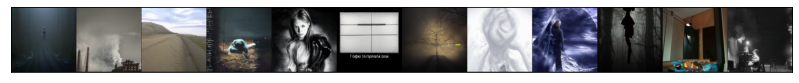

In [ ]:
#@title Image Settings
#@markdown This section is definining your settings. 
#@markdown * top_k is a mathematical equation that specifies the values for the next token
#@markdown * top_p is a probability distribution, which means the higher the number the more likely the image(s) generated will match what you say.
#@markdown * images_num is how many images you want to generate
dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device='cuda')

text = 'Wasteland' #@param {type:"string"}
text = translators.google(text, from_language='en', to_language='ru')

seed_everything(6955)
#codebooks = []
#for top_k, top_p, images_num in [
#    (2048, 0.995, 8),
#    (1536, 0.99, 8),
#    (1024, 0.99, 8),
#    (1024, 0.98, 8),
#    (512, 0.97, 8),
#    (384, 0.96, 8),
#    (256, 0.95, 8),
#    (128, 0.95, 8),
#]:
#    codebooks += generate_codebooks(text, tokenizer, dalle, top_k=top_k, images_num=images_num, top_p=top_p, bs=DALLE_BS)

#below is my stuff to limit one generation. Above is original stuff
top_k = 2048 #@param {type:"slider", min:64, max:2048, step:64} 
#top_k = "1024" #@param['2048', '1536', '1024', '512', '384', '256', '128'] {type:"number"}
#top_p = "0.98" #@param['0.95', '0.96', '0.97', '0.98', '0.99', '0.995'] {type:"number"}
top_p = 0.995 #@param {type:"slider", min:0.950, max:0.995, step:0.005}
images_num = 12 #@param {type:"slider", min:1, max:12, step:1}
codebook = generate_codebooks(text, tokenizer, dalle, top_k=top_k, images_num=images_num, top_p=top_p, bs=DALLE_BS)

#create the images
pil_images = []
for _codebooks in tqdm(torch.cat(codebook).cpu()):
    with torch.no_grad():
        images = vae.decode(_codebooks.unsqueeze(0))
        pil_images += torch_tensors_to_pil_list(images)

#display images
show(pil_images, images_num) #originally 8, replaced with images_num

In [ ]:
#@title Select your image
#@markdown Pick the image number from above you want in high resolution from left-to-right
#title Cherry Pick Images
#markdown This uses a scoring system based on "how closely does each image match what I told it to."
#markdown * pick_count = How many images should be picked (cannot be more than images_num)
#markdown * col_count = How many columns of images to display (grid formatting)

#pick_count = 1 #@param {type:"slider", min:1, max:12, step:1}
#col_count = 1 #@param {type:"slider", min:1, max:4, step:1}

image_select = 2 #@param {type:"slider", min:1, max:12, step:1}
highres = True #@param {type:"boolean"}
image_select -= 1

#top_images = pil_images[6]
img = pil_images[image_select]
display(img)
#top_images, clip_scores = cherry_pick_by_clip(pil_images, text, ruclip, ruclip_processor, device='cpu', count=pick_count) #originally 6, replaced with pick_count
#show(top_images, col_count) #initially 3, replaced with col_count

#built off super_resolution function 
def super_resolutionsingle(pil_image, realesrgan, batch_size=4):
    with torch.no_grad():
      sr_image = realesrgan.predict(img, batch_size=batch_size)
    return sr_image

#resolution preparation
if highres:
    from rudalle.pipelines import super_resolution
    from rudalle import get_realesrgan
    
    device = 'cuda'
    dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)
    dalle = dalle.to('cpu')
    del dalle
    import gc
    torch.cuda.empty_cache()
    gc.collect()

    realesrgan = get_realesrgan('x2', device=device, fp16=True)

  #print out high resolution
if highres:
  sr_image = super_resolutionsingle(img, realesrgan, batch_size=1)
  #sr_images = super_resolutionsingle(img, realesrgan, batch_size=1)
  #show(sr_images, 1)
  display(sr_image)


## License

MIT License

Copyright (c) 2021 Ray Krehn

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
